In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli
from tqdm.notebook import tnrange

## Расчет прохождения нейтронов сквозь пластинку методом Монте-Карло

Отметим, что во время движения нас волнует только 2 параметра - координата $z$ (нужно понимать, когда частица вылетает из пластинки) и угол $\theta$ между осью $z$ и направлением движения (он нужен для вычисления z и для вычисления нового угла $\theta$ в случае анизотропного рассеяния).

In [2]:
def distance_to_collision():
    return -Lambda*np.log(1 - np.random.random())


def get_isotropic_direction(*args):
    # Возвращает угол teta между осью z и новым направлением движения из изотропного распределения методом обратной функции
    # np.random.random() - равномерная случайная величина на [0, 1)
    return np.arccos(1 - 2*np.random.random())


def zero_direction(*args):
    # Возвращает нулевой угол teta - для случая прямолинейного движения
    return 0


def prob_density(teta):
    # Плотность вероятности teta для анизотропного случая
    # Интеграл от 0 до pi нормирован на 1, максимум функции 1/sqrt(3)
    return np.cos(teta/2)*np.sin(teta)*3/4


def get_nu():
    # Возвращает угол nu (полярный угол между старым и новым направлением движения) из распределения выше методом Неймана
    M = 1/np.sqrt(3)
    while True:
        nu = np.random.random()*np.pi
        check = np.random.random()*M
        if prob_density(nu) > check:
            return nu


def non_isotropic_direction(teta):
    # Возвращает новый угол teta (между осью z и направлением движения) после рассеяния
    nu = get_nu()
    phi = np.random.random()*2*np.pi
    
    return np.arccos(np.cos(teta)*np.cos(nu) - np.sin(teta)*np.cos(phi)*np.sin(nu))


def is_absorbed():
    # Возвращает True, если частица поглотилась (вероятность этого -  p), иначе - False
    if bernoulli.rvs(p) == 1:
        return True
    else:
        return False

    
def is_outside(z):
    # Возвращает True, если частица все еще внутри образца
    if z < 0 or z > H:
        return True
    else:
        return False

    
def single_experiment(get_direction=get_isotropic_direction):
    # Симулирует одиночный эксперимент
    # Возвращает 0 - поглощение, 1 - отражение, 2 - прохождение
    z = 0
    teta = 0
    
    while True:
        z += distance_to_collision()*np.cos(teta)
        
        if is_outside(z):
            return 1 if teta > np.pi/2 else 2
        
        elif is_absorbed(): 
            return 0
        
        else:
            teta = get_direction(teta)
            
    
def multiple_experiments(N, get_direction=get_isotropic_direction):
    # Симулирует N экспериментов
    # Возвращает кортеж (p_absorbtion, p_reflection, p_passing)
    cnt_abs = 0
    cnt_ref = 0
    
    for i in tnrange(N):
        result = single_experiment(get_direction=get_direction)
        if result == 0:
            cnt_abs += 1
        elif result == 1:
            cnt_ref += 1
        
    return (cnt_abs/N, cnt_ref/N, (N - cnt_abs - cnt_ref)/N)

Протестируем генерацию анизотропного распределения методом Неймана.

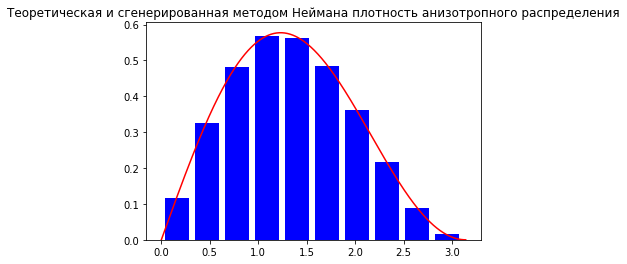

In [3]:
nu_range = [get_nu() for _ in tnrange(100000)]
_ = plt.hist(nu_range, rwidth=0.8, color='blue', density=True)

x_range = np.linspace(0, np.pi, num=1000)
_ = plt.plot(x_range, prob_density(x_range), color='red')

_ = plt.title('Теоретическая и сгенерированная методом Неймана плотность анизотропного распределения')

In [4]:
p = 0.4 # Вероятность поглощения
H = 1
Lambda = 0.3
N = 5000000

In [5]:
def print_results(absorbtion, reflection, passing, title):
    print(title)
    print('Вероятность поглощения:', absorbtion)
    print('Вероятность отражения:', reflection)
    print('Вероятность прохождения:', passing)

In [6]:
p_abs_isotropic, p_ref_isotropic, p_pas_isotropic = multiple_experiments(N, get_direction=get_isotropic_direction)
print_results(p_abs_isotropic, p_ref_isotropic, p_pas_isotropic, "Случай изотропного рассеяния")


Случай изотропного рассеяния
Вероятность поглощения: 0.7758246
Вероятность отражения: 0.1547198
Вероятность прохождения: 0.0694556


Заметим, что для изотропного рассеяния, вероятность отражения выше вероятности прохождения, что логично - первое столкновение в среднем происходит на расстоянии $\lambda = 0.3$ от первого края пластины, а дальше идет процесс случайных блужданий, где шаг в прямом и обратном направлении равновероятны, единственнное отличие - первый край пластины ближе, чем второй.

In [7]:
p_abs_straight, p_ref_straight, p_pas_straight = multiple_experiments(N, get_direction=zero_direction)
print_results(p_abs_straight, p_ref_straight, p_pas_straight, "Случай сильно анизотропного рассеяния")


Случай сильно анизотропного рассеяния
Вероятность поглощения: 0.7363904
Вероятность отражения: 0.0
Вероятность прохождения: 0.2636096


Характерное отличие сильно анизотропного рассеяния - меньшая вероятность поглощения, т.к. в среднем испытвается меньшее количество столкновений. Частица летит строго прямо, поэтому нет вероятности застрять где-то посередине пластины, колеблясь вперед-назад.

In [8]:
p_abs_anisotropic, p_ref_anisotropic, p_pas_anisotropic = multiple_experiments(N, get_direction=non_isotropic_direction)
print_results(p_abs_anisotropic, p_ref_anisotropic, p_pas_anisotropic, "Случай анизотропного рассеяния")


Случай анизотропного рассеяния
Вероятность поглощения: 0.8015556
Вероятность отражения: 0.1167972
Вероятность прохождения: 0.0816472


В случае анизотропного рассеяния с сечением $ \sigma(\theta) = cos(\frac{\theta}{2})$, как и ожидалось, вероятность отражения уменьшилась, ведь теперь лишь 14% частиц отражаются назад после однократного рассеяния. Другой вариант вылететь назад - претерпеть многократное рассеяние на небольшие углы, получив суммарный разворот на ~$\pi$. Но при многократном рассеянии вероятность поглощения сильно вырастает. Таким образом, часть вероятности отражения "переехала" в вероятность поглощения, часть - в вероятность прохождения.